## mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


##set file parth


In [37]:
%cd /content/drive/MyDrive/Crypto_Analysis

/content/drive/MyDrive/Crypto Analysis


In [ ]:
!pip install numpy pandas scikit-learn tensorflow matplotlib


# Import liblaries


In [75]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Load the data

In [76]:
# Load the data
df = pd.read_csv('ETC_historical.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [65]:
#df = df.iloc[:-4]


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-03-19 to 2025-03-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


#Normalize the data

In [78]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create Sequences for LSTM

In [68]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [79]:
seq_length = 100  # Use 60 days of historical data to predict the next day
X, y = create_sequences(scaled_data, seq_length)

#Split the data into training and testing sets


In [80]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Build and train the LSTM model

In [81]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.1188 - val_loss: 0.1192
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0641 - val_loss: 0.0437
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0292 - val_loss: 0.0093
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0277 - val_loss: 0.0063
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0230 - val_loss: 0.0101
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0182 - val_loss: 0.0041
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0156 - val_loss: 0.0057
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0173 - val_loss: 0.0088
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0084 - val_loss: 0.0150
Epoch

#Mean Squared Relative Error


In [82]:
import numpy as np

def calculate_msre(y_true, y_pred):
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = np.square(relative_errors)
    msre = np.mean(squared_relative_errors)
    return msre

# Example usage
y_true = np.array([10, 20, 30, 40, 50])
y_pred = np.array([9, 21, 31, 38, 52])

msre = calculate_msre(y_true, y_pred)
print(f"Mean Squared Relative Error: {msre}")


Mean Squared Relative Error: 0.003542222222222223


#Make predictions for the next 5 days

In [83]:
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(5):
    next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)

# Inverse transform the predictions
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generate dates for the predictions
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5)

# Create a DataFrame with the predictions
future_predictions = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted Price'])
print(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
            Predicted Price
2025-03-19        18.264456
2025-03-20        18.190912
2025-03-21        18.154221
2025-03-22        18.140762
2025-03-23        18.142090


# Visualize the results


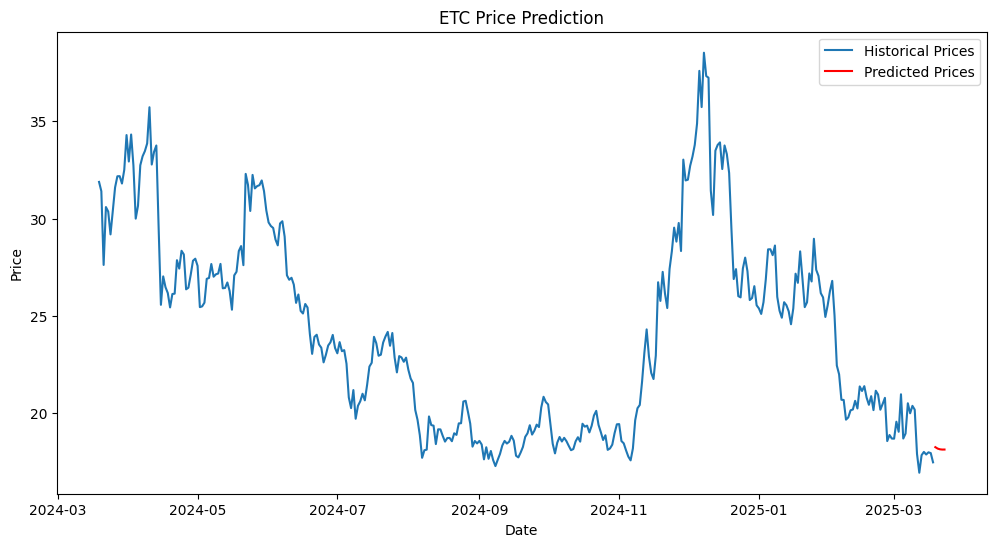

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical Prices')
plt.plot(future_dates, predicted_prices, label='Predicted Prices', color='red')
plt.title('ETC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
